## Import Libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
from google.colab.patches import cv2_imshow
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml

--2023-04-24 16:51:54--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341406 (333K) [text/plain]
Saving to: ‘haarcascade_eye.xml’

haarcascade_eye.xml 100%[===================>] 333.40K  --.-KB/s    in 0.04s   

2023-04-24 16:51:54 (7.86 MB/s) - ‘haarcascade_eye.xml’ saved [341406/341406]



## Part 1: Align Images

### functions

In [ ]:
def show_two_images(first_image, second_image):
    first_image = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)
    second_image = cv2.cvtColor(second_image, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(first_image)
    plt.subplot(1, 2, 2)
    plt.imshow(second_image)
    plt.show()


def fit_size(source, target): 
     return cv2.resize(target, (source.shape[1], source.shape[0]))


def detect_eyes(image, show=False):
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(image, 1.1, 8)

    eyes_centers = []
    deteceted_image = image.copy()
    for (x,y,w,h) in eyes:
        x_center, y_center = (x+w/2).astype(np.int32), (y+h/2).astype(np.int32)
        eyes_centers.append((x_center, y_center))
        cv2.rectangle(deteceted_image, (x_center-1, y_center-1), (x_center+1, y_center+1), (0, 255, 0), 7)
    eyes_centers.sort(key=lambda a: a[0])

    if show:
        plt.imshow(deteceted_image)
        plt.show()

    return deteceted_image, eyes_centers


def align_eyes(source_eyes, target_eyes, target):
    M = np.eye(3, dtype=np.float32)

    # align x-axis
    M[0, 0] = (source_eyes[1][0] - source_eyes[0][0]) / (target_eyes[1][0] - target_eyes[0][0])
    M[0, 2] = source_eyes[0][0] - M[0, 0] * target_eyes[0][0]
    # M[0, 0] = 1

    # align y-axis
    M[1, 0] = (source_eyes[1][1] - source_eyes[0][1] - (target_eyes[1][1] - target_eyes[0][1])) / (target_eyes[1][0] - target_eyes[0][0])
    M[1, 2] = source_eyes[0][1] - target_eyes[0][1] -  M[1, 0] * target_eyes[0][0]
    # M[1, 1] = (source_eyes[1][1] - source_eyes[0][1]) / (target_eyes[1][1] - target_eyes[0][1])
    # M[1, 2] = source_eyes[0][1] - M[1, 1] * target_eyes[0][1]

    rows, cols, _ = target.shape
    scaled_img = cv2.warpPerspective(target, M, (cols, rows))
    return scaled_img

def align(source_center, target_center, target):
    M = np.eye(3, dtype=np.float32)
    M[0, 2] = source_center[0] - target_center[0]
    M[1, 2] = source_center[1] - target_center[1]
    rows, cols, _ = target.shape
    scaled_img = cv2.warpPerspective(target, M, (cols, rows))
    return scaled_img

### Load Images

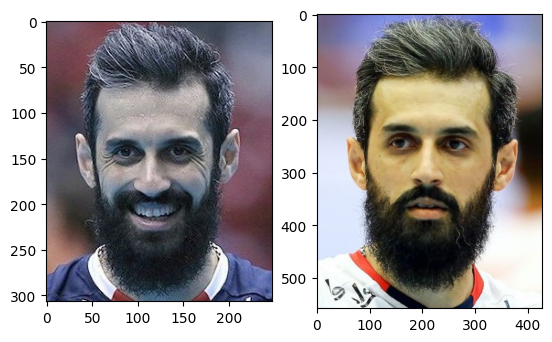

In [ ]:
wavelet_near = cv2.imread("wav2.jpg")
wavelet_far = cv2.imread("wav1.jpg")

show_two_images(wavelet_near, wavelet_far)

### Align images

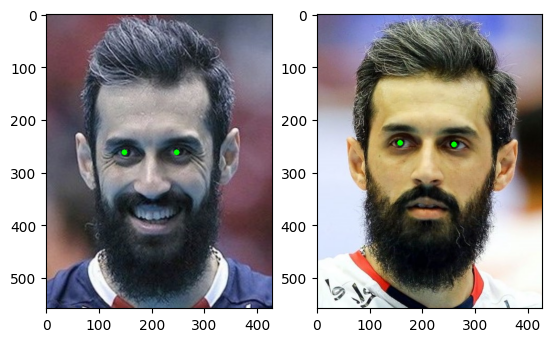

[(148, 262), (247, 262)] [(157, 244), (259, 247)]


In [ ]:
# step 1: fit size
wavelet_near = fit_size(wavelet_far, wavelet_near)

# step 2: detect eyes
detected_near, eyes_near = detect_eyes(wavelet_near)
detected_far, eyes_far = detect_eyes(wavelet_far)
show_two_images(detected_near, detected_far)

print(eyes_near, eyes_far)

In [ ]:
# step 3: align eyes
scaled_img = align_eyes(eyes_near, eyes_far, wavelet_far)

# save aligned image
cv2.imwrite('wavelet-near-aligned.jpg', wavelet_near)
cv2.imwrite('wavelet-far-aligned.jpg', scaled_img)

True

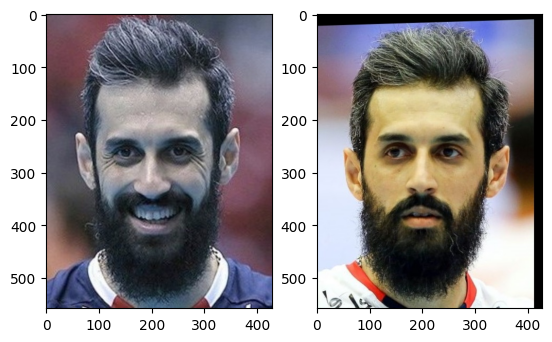

In [ ]:
wavelet_near_aligned = cv2.imread("wavelet-near-aligned.jpg")
wavelet_far_aligned = cv2.imread("wavelet-far-aligned.jpg")

show_two_images(wavelet_near_aligned, wavelet_far_aligned)

In [ ]:
wavelet_near_aligned = wavelet_near_aligned[20:, :400]
wavelet_far_aligned = wavelet_far_aligned[20:, :400]

cv2.imwrite('wavelet-near-aligned.jpg', wavelet_near_aligned)
cv2.imwrite('wavelet-far-aligned.jpg', wavelet_far_aligned)

True

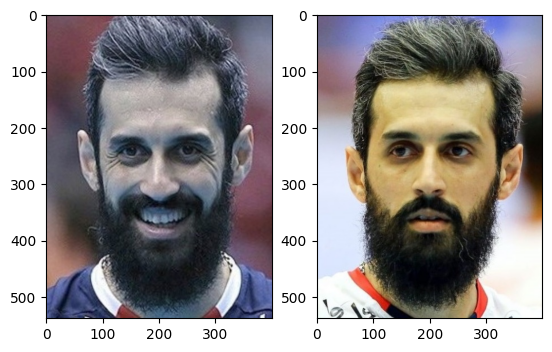

In [ ]:
wavelet_near_aligned = cv2.imread("wavelet-near-aligned.jpg")
wavelet_far_aligned = cv2.imread("wavelet-far-aligned.jpg")

show_two_images(wavelet_near_aligned, wavelet_far_aligned)

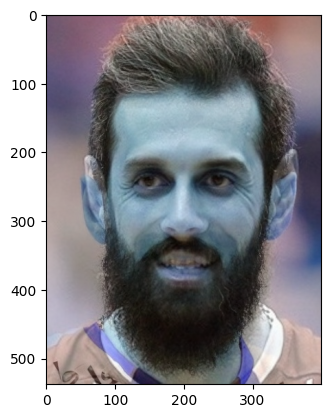

In [ ]:
plt.imshow(wavelet_near_aligned)
plt.imshow(wavelet_far_aligned, alpha=0.5)
plt.show()

## Part 2: Wavelet Transform

In [ ]:
def highpass_filter(img):
    # Perform wavelet transform
    coeffs = pywt.dwt2(img, 'db1')

    kernel = np.array([[0,-1,0], [-1 ,5, -1], [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)
    # kernel = np.array([[-1,-2,-1], [0 ,0, 0], [1, 2, 1]])
    # img1 = cv2.filter2D(img, -1, kernel)
    # kernel = np.array([[-1, 0, 1], [-2 ,0, 2], [-1, 0, -1]])
    # img2 = cv2.filter2D(img, -1, kernel)
    # img = np.sqrt(img1 ** 2 + img2 ** 2).astype(np.uint8)

    # Perform wavelet transform
    coeffs0 = pywt.dwt2(img, 'db1')

    # Extract approximation and detail coefficients
    cA, (cH, cV, cD) = coeffs0

    # cH_filt = pywt.threshold(cH, value=50, mode='soft', substitute=0)
    # cV_filt = pywt.threshold(cV, value=50, mode='soft', substitute=0)
    # cD_filt = pywt.threshold(cD, value=50, mode='soft', substitute=0)
    # cA_filt = pywt.threshold(cA, value=0.05, mode='soft', substitute=0)
    cA_filt = 0.8 * cA

    # Reconstruct image from filtered coefficients
    coeffs_filt = (cA_filt, (cH, cV, cD))
    img_filt = pywt.idwt2(coeffs_filt, 'db1')
    return coeffs, img_filt, coeffs_filt

def lowpass_filter(img):
    # Perform wavelet transform
    coeffs = pywt.dwt2(img, 'db1')

    kernel = np.ones((5, 5), np.float32) / 25
    img = cv2.filter2D(img, -1, kernel)

    coeffs0 = pywt.dwt2(img, 'db1')

    # Extract approximation and detail coefficients
    cA, (cH, cV, cD) = coeffs0

    # cA_filt = pywt.threshold(cA, value=50, mode='soft', substitute=0)
    cA_filt = cA

    # Reconstruct image from filtered coefficients
    coeffs_filt = (cA_filt, (0.1 * cH, 0.1 * cV, 0.1 * cD))
    img_filt = pywt.idwt2(coeffs_filt, 'db1')
    return coeffs, img_filt, coeffs_filt

def show_dwt(coeffs, save=False, filename='untitle'):
    cA, (cH, cV, cD) = coeffs
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(cA.astype('int'), 'gray')
    plt.subplot(2, 2, 2)
    plt.imshow(cH.astype(np.uint8), 'gray')
    plt.subplot(2, 2, 3)
    plt.imshow(cV.astype(np.uint8), 'gray')
    plt.subplot(2, 2, 4)
    plt.imshow(cD.astype(np.uint8), 'gray')
    if save:
        plt.savefig(f'{filename}.jpg')
    plt.show()

In [ ]:
img1 = cv2.imread("wavelet-near-aligned.jpg")
img2 = cv2.imread("wavelet-far-aligned.jpg")

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

coeffs1, img1_filt, coeffs1_filt = highpass_filter(gray1)
coeffs2, img2_filt, coeffs2_filt = lowpass_filter(gray2)

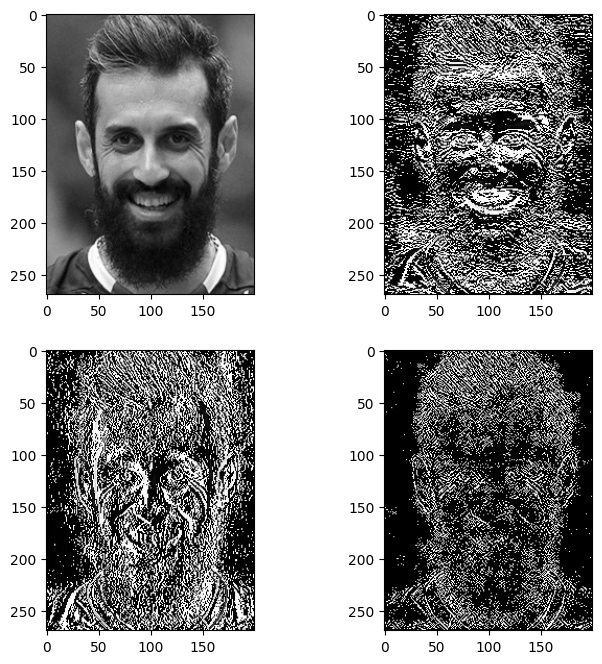

In [ ]:
show_dwt(coeffs1, save=True, filename='wavelet-near-dwt')

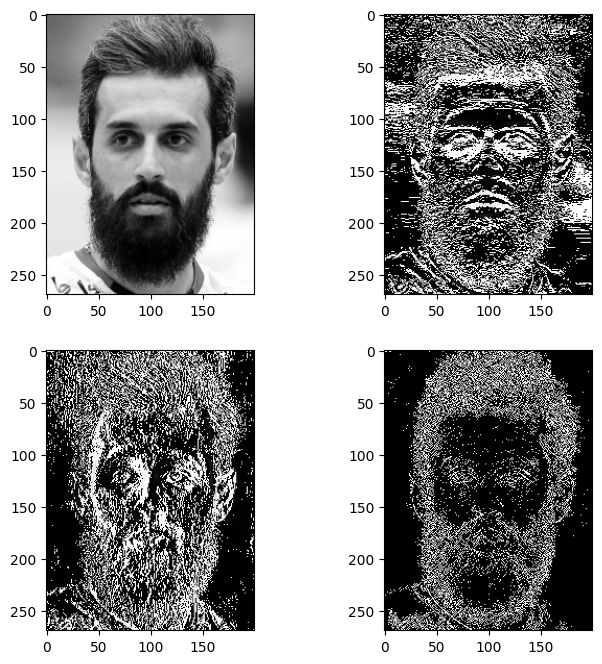

In [ ]:
show_dwt(coeffs2, save=True, filename='wavelet-far-dwt')

In [ ]:
coeffs = [coeffs2_filt[0] * 0.6 + 0.4 * coeffs1_filt[0], (coeffs1_filt[1][0], coeffs1_filt[1][1], coeffs1_filt[1][2]*0.5+0*coeffs2_filt[1][0])]

# Reconstruct the hybrid image
hybrid = pywt.idwt2(coeffs, 'db1')

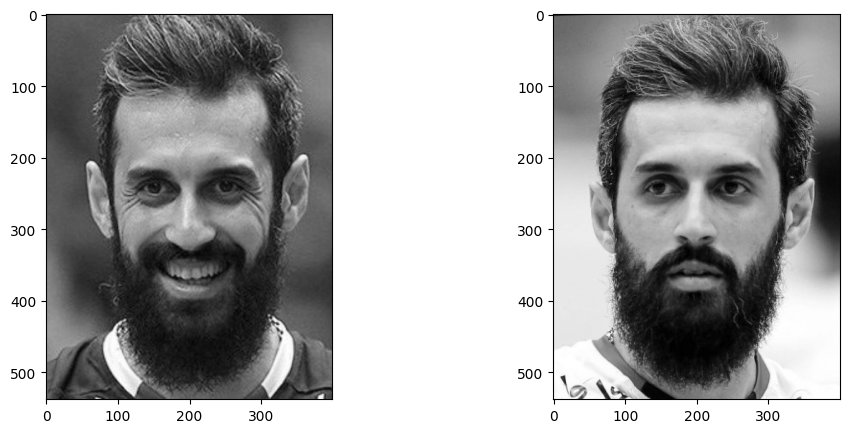

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray1, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(gray2, 'gray')
plt.show()

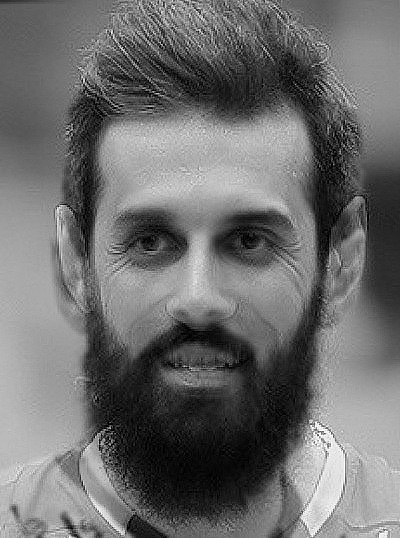

In [ ]:
cv2_imshow(hybrid)

In [ ]:
cv2.imwrite('wavelet-hybrid.jpg', hybrid)

True

Explanation of the algorithm above:

1. Load two images, convert them to grayscale, and convert them to floating point.


2. Perform a 2D discrete wavelet transform (DWT) on both images using the same wavelet. This will produce four sets of coefficients for each image: approximation coefficients (cA) and three sets of detail coefficients (cH, cV, cD).

3. Combine the approximation coefficients of one image with the detail coefficients of the other image. This can be done by keeping the approximation coefficients from one image and replacing the detail coefficients with those from the other image.

4. Perform an inverse 2D DWT on the combined coefficients to obtain the hybrid image.

The key step in creating the hybrid image is to combine the approximation coefficients of one image with the detail coefficients of the other image. The approximation coefficients contain the low-frequency information, while the detail coefficients contain the high-frequency information. By combining these coefficients, we create an image that contains both the low-frequency information from one image and the high-frequency information from the other image.